# Modelos de analise de sentimentos

In [1]:
from pysentimiento import create_analyzer
import nltk
from nltk.corpus import stopwords
import polars as pl
from plotly import express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sys
import os

## Testando modelos de analise de sentimentos

In [2]:
modelo = 'pysentimiento/bertweet-pt-sentiment'

In [3]:
modelo_analise_sentimento = create_analyzer(task='sentiment', lang='pt')

In [4]:
sentimentos_dict = {
    'NEG': 'Negativo',
    'NEU': 'Neutro',
    'POS': 'Positivo'
}

In [5]:
def analisar_sentimento(texto):
    resultado = modelo_analise_sentimento.predict(texto)
    return '\n'.join([
        f'Sentimento: {sentimentos_dict.get(resultado.output)}',
        'Confiança: ',
        f'\tNegativo: {resultado.probas.get("NEG")}',
        f'\tNeutro: {resultado.probas.get("NEU")}',
        f'\tPositivo: {resultado.probas.get("POS")}'
    ])

In [6]:
print(analisar_sentimento("Eu odeio quando a internet não funciona"))

Sentimento: Negativo
Confiança: 
	Negativo: 0.9838698506355286
	Neutro: 0.009782686829566956
	Positivo: 0.006347368936985731


In [7]:
print(analisar_sentimento('Eu odeio este produto!'))

Sentimento: Negativo
Confiança: 
	Negativo: 0.9920969009399414
	Neutro: 0.0034392480738461018
	Positivo: 0.004463882651180029


In [8]:
print(analisar_sentimento('Estes produtos foram vendidos fora da data de entrega'))

Sentimento: Neutro
Confiança: 
	Negativo: 0.16409549117088318
	Neutro: 0.8187859654426575
	Positivo: 0.017118575051426888


In [9]:
print(analisar_sentimento('O melhor produtos de todos, mas tem suas resalvas devido fazer muito barulho.'))

Sentimento: Neutro
Confiança: 
	Negativo: 0.15663763880729675
	Neutro: 0.5257287621498108
	Positivo: 0.31763359904289246


## Carragando os dados para analise de sentimentos

In [10]:
df = pl.read_csv('../dados/resenhas.csv')

In [11]:
df = df.sort('ID')

In [12]:
for row in df.iter_rows():
    print(f'ID: {row[0]}', analisar_sentimento(row[1]), sep='\n')

ID: 21
Sentimento: Neutro
Confiança: 
	Negativo: 0.3315524458885193
	Neutro: 0.6556147336959839
	Positivo: 0.012832829728722572
ID: 24
Sentimento: Positivo
Confiança: 
	Negativo: 0.002398931887000799
	Neutro: 0.008684467524290085
	Positivo: 0.9889166355133057
ID: 47
Sentimento: Positivo
Confiança: 
	Negativo: 0.0020241455640643835
	Neutro: 0.010792884044349194
	Positivo: 0.9871829748153687
ID: 62
Sentimento: Negativo
Confiança: 
	Negativo: 0.9854169487953186
	Neutro: 0.011170672252774239
	Positivo: 0.0034124357625842094
ID: 121
Sentimento: Negativo
Confiança: 
	Negativo: 0.9683650135993958
	Neutro: 0.026900380849838257
	Positivo: 0.004734572023153305
ID: 123
Sentimento: Negativo
Confiança: 
	Negativo: 0.9923976063728333
	Neutro: 0.005028190556913614
	Positivo: 0.002574155805632472
ID: 135
Sentimento: Negativo
Confiança: 
	Negativo: 0.9631906151771545
	Neutro: 0.03116423264145851
	Positivo: 0.005645196419209242
ID: 182
Sentimento: Positivo
Confiança: 
	Negativo: 0.06887587159872055
	Neu

In [13]:
sentimentos = df["Resenha"].map_elements(modelo_analise_sentimento.predict, return_dtype=pl.Object)

In [14]:
df = df.with_columns([
    pl.Series("Sentimento", sentimentos.map_elements(lambda x: sentimentos_dict.get(x.output), return_dtype=pl.Utf8)),
    pl.Series("Confiança Negativo", sentimentos.map_elements(lambda x: x.probas.get("NEG"), return_dtype=pl.Float32),),
    pl.Series("Confiança Neutro", sentimentos.map_elements(lambda x: x.probas.get("NEU"), return_dtype=pl.Float32)),
    pl.Series("Confiança Positivo", sentimentos.map_elements(lambda x: x.probas.get("POS"), return_dtype=pl.Float32))
])

In [15]:
df

ID,Resenha,Sentimento,Confiança Negativo,Confiança Neutro,Confiança Positivo
i64,str,str,f32,f32,f32
21,"""Aparelho bom, mas a sua tampa …","""Neutro""",0.331552,0.655615,0.012833
24,"""A fritadeira é sensacional, mu…","""Positivo""",0.002399,0.008684,0.988917
47,"""Achei bem boa e super fácil de…","""Positivo""",0.002024,0.010793,0.987183
62,"""Infelizmente começa a enferruj…","""Negativo""",0.985417,0.011171,0.003412
121,"""Não recomendo esse aparelho! A…","""Negativo""",0.968365,0.0269,0.004735
…,…,…,…,…,…
815,"""Chegou no prazo. Amei, é muito…","""Positivo""",0.001801,0.007927,0.990272
847,"""Linda em design, ótimos funcio…","""Negativo""",0.968544,0.012949,0.018506
865,"""Muito funcional, prática e mod…","""Positivo""",0.003003,0.096854,0.900143


## Renderizando grafico

In [16]:
px.pie(df.to_pandas(), names='Sentimento', title='Distribuição de sentimentos')

In [17]:
nltk.download('stopwords')
print(stopwords.words('portuguese'))

In [18]:
portuguese_stopwords = stopwords.words('portuguese')

In [19]:
def nuvem_palavras(df, sentimento):
    texto = ' '.join(df.filter(df['Sentimento'] == sentimento)['Resenha'].to_numpy())

    wordcloud = WordCloud(stopwords=portuguese_stopwords, width=800, height=500, max_words=100, background_color='black').generate(texto)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Sentimentos positivos

[nltk_data] Downloading package stopwords to /home/alfa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


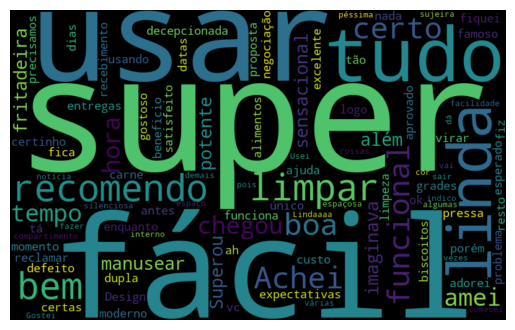

In [20]:
nuvem_palavras(df, 'Positivo')

### Sentimentos negativos

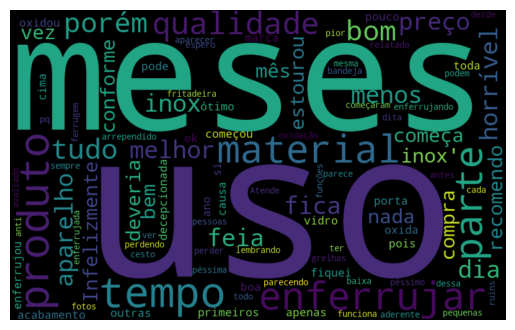

In [21]:
nuvem_palavras(df, 'Negativo')

### Sentimentos neutros

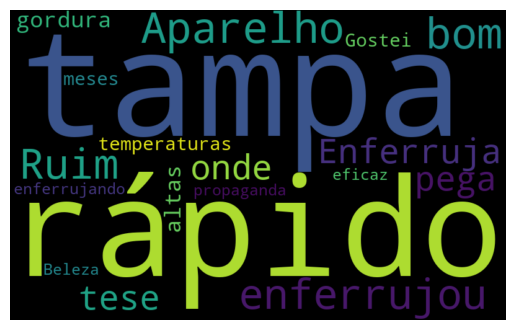

In [22]:
nuvem_palavras(df, 'Neutro')